# Modal Tutorial 02: Basics of Vibrations
Before looking too much into modal analysis, we will take a step back and look at a more fundamental phenomenon in structural dynamics: vibrations.

## A Simple Undamped Spring-Mass System

Vibrations occur primarily due to the presence of a kind of restoring force that acts against the deflection of the part.  For example, if you stretch a spring, the spring pulls back against your hand.  To stretch the spring farther, we would need to apply a larger force.  When we let go of the stretched spring, the spring accelerates back towards its undeformed state.  This acceleration implies that a force was present, though none is being applied to the spring.  This force is "internal" to the spring, due to the attraction of all the atoms and molecules making up the spring.

When the spring arrives back at its deformed position, it does not suddenly come to rest.  Indeed, as the force is pulling the spring back to its original position, it is constantly accelerating, so it arrives back at its undeformed position with a good deal of velocity, and with there now being zero internal forces at the undeformed position, there will be no forces slowing the spring down, so it will continue to travel on past its original point.  At this point, the spring is now stretching itself in the opposite direction, so internal forces develop slowing the spring down.  Eventually, the forces overcome the velocity of the spring and accelerate it back to the undeformed position, where it returns to again with velocity.  This process repeats over and over, and so we say the spring "vibrates".

Let's look at an example.  Pretend we have a spring with spring constant $k$ and a block on the end of the spring with mass $m$.  We will assume that the mass of $m$ is much larger than the mass of the spring, so we will make an approximation that there is no contribution to the mass of the system due to the spring.  An external force $f$ may be applied to the mass to set it in motion.

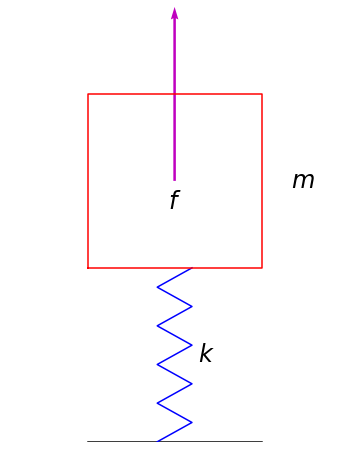

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.animation import FuncAnimation as fa
import numpy as np
import sdynpy as sdpy

def draw_spring_mass(deflection = 0, mass_size = 0.5,
                     mass_to_ground_length = 0.75, num_windings = 5,
                     spring_width = 0.1,arrow_sizes=[],arrow_labels=[],
                     arrow_colors=[], arrow_offset = None,
                     axis = None,fontsize=24):
    spring_length = mass_to_ground_length - mass_size/2 + deflection
    ground_position = -mass_to_ground_length
    if axis is None:
        fig,axis = plt.subplots(figsize=(6,8))
    # Draw the ground
    axis.plot([-mass_size/2,mass_size/2],
              [ground_position,ground_position],'k')
    # Draw the spring
    axis.plot([(i%2)*spring_width - spring_width/2 for i in range(num_windings*2)],
              np.linspace(ground_position,ground_position+spring_length,num_windings*2),'b')
    # Draw the mass
    mass_x,mass_y = np.meshgrid([-mass_size/2,mass_size/2],
                                [-mass_size/2,mass_size/2],indexing='ij')
    mass_x = mass_x.flatten()
    mass_y = mass_y.flatten()
    mass_x = mass_x[[0,1,3,2,0]]
    mass_y = mass_y[[0,1,3,2,0]]
    axis.plot(mass_x.flatten(),mass_y.flatten()+deflection,'r')
    axis.text(mass_size*2/3,deflection,'$m$',fontsize=fontsize,
              ha='left',va='center')
    axis.text(spring_width*2/3,ground_position + spring_length/2,'$k$',
             fontsize=fontsize,ha='left',va='center')
    num_arrows = min([len(arrow_sizes),len(arrow_labels),
                     len(arrow_colors)])
    if arrow_offset is None:
        if num_arrows > 1:
            arrow_offset = mass_size/(num_arrows+2)
        else:
            arrow_offset = 0.0
    if num_arrows > 0:
        arrow_positions = np.arange(num_arrows+2)*arrow_offset
        mean_position = np.mean(arrow_positions)
        arrow_positions -= mean_position
        arrow_positions = arrow_positions[1:-1]
    for size,label,color,position in zip(arrow_sizes,
                                         arrow_labels,
                                         arrow_colors,
                                         arrow_positions):
        axis.quiver(position,deflection,0,size,scale=1,color=color,
                   angles='xy',scale_units='xy')
        axis.text(position,deflection + mass_size/20*(-1 if size > 0 else 1),
                  label,ha='center',va='top' if size > 0 else 'bottom',
                 fontsize=fontsize)

fig,axis = plt.subplots(figsize=(6,8))
axis.axis('off')
axis.axis('equal')
axis.set_ylim(-0.75,0.5)
draw_spring_mass(axis=axis,arrow_sizes = [0.5],
                 arrow_labels=['$f$'],arrow_colors=['m'])

If we draw a free-body diagram of the mass, we will see that the that the acceleration of the mass due to external forces will be 

$$f - kx = m\ddot{x}$$

where $f$ is the external force, $k$ is the spring stiffness, $x$ is displacement of the mass, $m$ is the mass of the mass, and $\ddot{x}$ is the double-time-derivative or acceleration of the mass.  This is the differential equation governing the motion of the mass.  Written another way, we have:

$$m\ddot{x} + kx = f$$

which is the more standard way to write the equation in structural dynamics, because it collects all the $x$-terms on the left side and the external forces on the right side of the equation.  Let's assemble a SDynPy system from this equation, and see what happens when it vibrates.  We will assign actual values to the mass $m$ and spring stiffness $k$ so we can simulate the spring's motion.

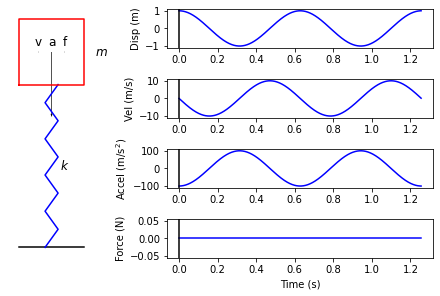

In [2]:
# Assign values to mass and stiffness
m = 1
k = 100
dof_name = sdpy.coordinate_array(1,2)
# Create a system object
system = sdpy.System(dof_name,m,k)
time_length = 2*np.pi*np.sqrt(m/k)

# Let's deflect the spring by x=1 and then let it go to see what happens
dt = time_length/1000*2
force_signal = np.zeros((1,1000))
initial_state = [1,0]
responses = []
for i in range(3):
    response,force = system.time_integrate(force_signal,dt,
                                           initial_state = initial_state,
                                           displacement_derivative=i)
    responses.append(response)
displacement,velocity,acceleration = responses

# Create a function to plot the response
def plot_spring_mass_response(displacement,velocity,acceleration,force,
                              displacement_index,drawing_axis = None,
                              disp_axis = None, vel_axis = None,
                              accel_axis = None, force_axis = None, dt = 1.0,
                              mass_size = 0.5,mass_to_ground_length = 1.0,
                              num_windings = 5,spring_width = 0.1,
                              fontsize=24
                              ):
    if any([ax is None for ax in [disp_axis,vel_axis,accel_axis,force_axis,
                                 drawing_axis]]):
        fig = plt.figure(constrained_layout=True,figsize=(6,4))
        spec = gs.GridSpec(4,4,figure=fig)
        drawing_axis = fig.add_subplot(spec[:, 0])
        disp_axis = fig.add_subplot(spec[0,1:])
        disp_axis.set_ylabel('Disp (m)')
        vel_axis = fig.add_subplot(spec[1,1:])
        vel_axis.set_ylabel('Vel (m/s)')
        accel_axis = fig.add_subplot(spec[2,1:])
        accel_axis.set_ylabel('Accel (m/s$^2$)')
        force_axis = fig.add_subplot(spec[3,1:])
        force_axis.set_ylabel('Force (N)')
        force_axis.set_xlabel('Time (s)')
        drawing_axis.axis('off')
        drawing_axis.axis('equal')
    times = np.arange(displacement.size)*dt
    if np.max(np.abs(displacement)) > 0:
        disp_size = displacement[displacement_index]/np.max(np.abs(displacement))*mass_size
    else:
        disp_size = 0
    if np.max(np.abs(velocity)) > 0:
        vel_size = velocity[displacement_index]/np.max(np.abs(velocity))*mass_size
    else:
        vel_size = 0
    if np.max(np.abs(acceleration)) > 0:
        accel_size = acceleration[displacement_index]/np.max(np.abs(acceleration))*mass_size
    else:
        accel_size = 0
    if np.max(np.abs(force)) > 0:
        force_size = force[displacement_index]/np.max(np.abs(force))*mass_size
    else:
        force_size = 0
    draw_spring_mass(disp_size,mass_size,mass_to_ground_length,
                     num_windings,spring_width,
                     arrow_sizes=[vel_size,accel_size,force_size],
                     arrow_labels=['v','a','f'],
                     arrow_colors=['k','k','k'],
                     arrow_offset = None,
                     axis = drawing_axis,fontsize=fontsize)
    disp_axis.plot(times,displacement,'b')
    disp_axis.axvline(times[displacement_index],color='k')
    vel_axis.plot(times,velocity,'b')
    vel_axis.axvline(times[displacement_index],color='k')
    accel_axis.plot(times,acceleration,'b')
    accel_axis.axvline(times[displacement_index],color='k')
    force_axis.plot(times,force,'b')
    force_axis.axvline(times[displacement_index],color='k')


plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          0, dt=dt,
                          fontsize=12)

We see here at the start of the response, just after the mass is released, it has zero velocity, unit displacement, and a signficant acceleration downward due to the internal stresses in the spring.  There are no external forces applied to the spring, so that remains zero over the entire time series.

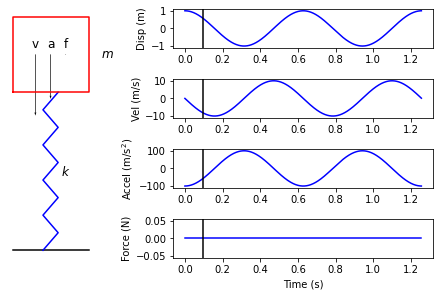

In [3]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          75, dt=dt,
                          fontsize=12)

A short time into the response, the mass has now acquired some velocity downward due to the internal force.  The spring is still stretched though, so the internal forces and thus acceleration are still accelerating the mass downward, so the velocity will continue to increase.

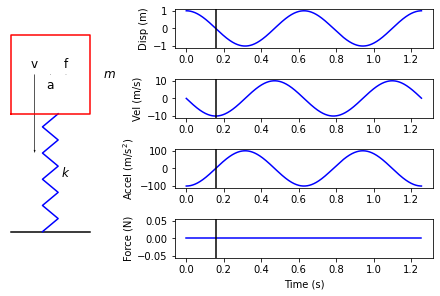

In [4]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          125, dt=dt,
                          fontsize=12)

At some point, the spring will cross through its undeformed state, and will therefore have zero internal force and zero acceleration applied to the mass.  However, because the mass still has a downward velocity, it will continue to travel downward due to its momentum.

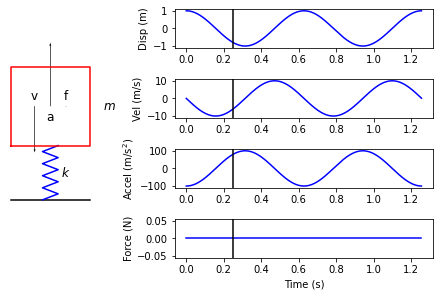

In [5]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          200, dt=dt,
                          fontsize=12)

Once the spring has passed through the undeformed point, the internal forces in the spring will attempt to push it back up, so while there is a downward velocity, the acceleration of the mass is in the upwards direction, so this downward velocity will decrease.

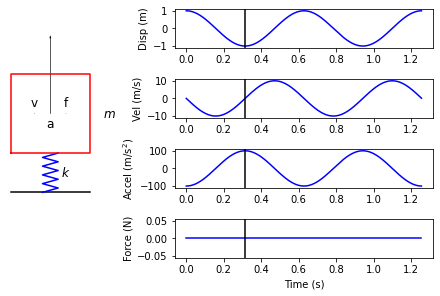

In [6]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          250, dt=dt,
                          fontsize=12)

Finally, the velocity slows to zero, and the mass comes to rest.  However, the spring is now compressed and the mass will be accelerated upwards.

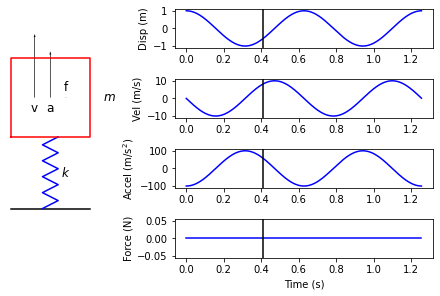

In [7]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          325, dt=dt,
                          fontsize=12)

The velocity increases as the mass is accelerated upwards.  As we pass the zero deflection point, the spring will start to pull downward on the mass and remove its upward velocity.

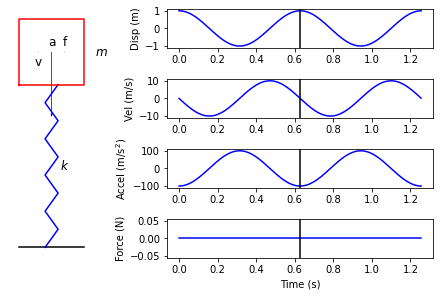

In [8]:
plot_spring_mass_response(displacement[0].ordinate,velocity[0].ordinate,
                          acceleration[0].ordinate,force[0].ordinate,
                          500, dt=dt,
                          fontsize=12)

Eventually, the mass will return to its starting point, and the cycle will begin again.

## Adding Damping
The above example showed that for the undamped system, the mass returned to its original conditions (displacement and velocity), and would therefore continue vibrating indefinitely.  Fortunately for structural dynamics engineers, no vibration is truly indefinite, as all motion will have some kind of losses or damping associated with it.  When a ball is bounced, it never returns to its original height.  When a guitar string is plucked, the sound eventually dies away.

To model the damping in the system, we apply an additional term to the differential equation of motion.  This term will be proportional to the velocity of the system.

$$m\ddot{x} + c\dot{x} + kx = f$$

Here $c$ is the damping of the system.  We can investigate our previous system to determine the effect of damping.  We will apply three different levels of damping to see what happens.

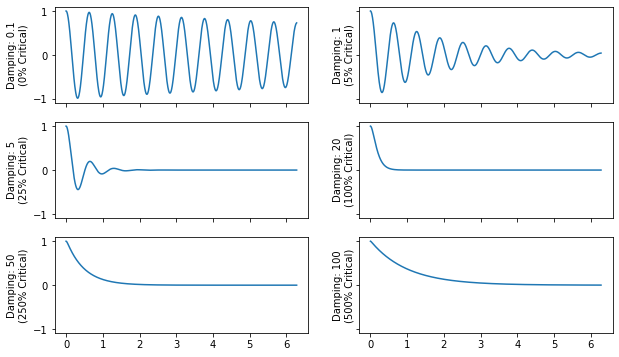

In [9]:
damping_values = [0.1,1,5,20,50,100]
time_length = 10*np.pi*np.sqrt(m/k)
# Let's deflect the spring by x=1 and then let it go to see what happens
dt = time_length/1000*2
force_signal = np.zeros((1,1000))
initial_state = [1,0]

responses = []
for c in damping_values:
    # Create a system object
    system = sdpy.System(dof_name,m,k,c)
    
    response,force = system.time_integrate(force_signal,dt,
                                           initial_state = initial_state,
                                           displacement_derivative=0)
    responses.append(response)
responses = np.concatenate(responses)

ax = responses.plot(one_axis=False,subplots_kwargs={'figsize':(10,6),'sharex':True,'sharey':True});
for c,a in zip(damping_values,ax.flatten()):
    a.set_ylabel('Damping: {:}\n({:.0f}% Critical)'.format(c,100*c/(2*np.sqrt(k*m))))

Obvious in the above plots is the fact that the response decays rather than oscillating at a constant amplitude indefinitely.  One may think that if damping is higher, the structure would more quickly return to zero motion, and that is true up to a point, which is called the critical damping.  Critical damping can be computed as
$$ c_{cr}=2\sqrt{km}$$
and is the damping value at which the system will most quickly return to zero, which for our system is $c=20$.  If damping is higher, it actually impedes the structure returning to zero.

## Response of Single Degree of Freedom Systems to Harmonic Excitation

The previous section considered free response of a single mass-spring-damping system.  This section will now consider the application of harmonic (sinusoidal) forces to the system.

### Undamped Response to Harmonic Excitation
Consider first the undamped case where we apply a sinusoidal excitation with angular frequency $\omega$ radians per second and amplitude $F$.  The equation of motion is

$$m\ddot{x}+kx=F \cos({\omega t})$$

Given that equation of motion, the solution will be of the form

$$x = X \cos(\omega t)$$

Plugging the solution into the original equation, we can obtain the amplitude of response $X$ due to the forced excitation.

$$ X = {F \over {k-m \omega^2}} $$

which we can solve for at any frequency $\omega$ except where $k-m\omega^2=0$ or $\omega = \sqrt{k/m}$.  The ratio of response amplitude $X$ over force amplitude $F$ is a kind of normalized factor that shows how the response is amplified at each frequency for a given force.

$${X\over F} = {1 \over {k-m \omega^2}}$$

This is a very important result in vibrations and modal analysis known as the **frequency response function**.  Let's plot it to see what it looks like.

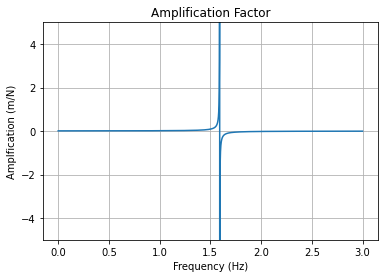

In [10]:
frequencies = np.linspace(0,3,5000)
amplification_factor = 1/(k-m*(2*np.pi*frequencies)**2)

fig,ax = plt.subplots()
ax.plot(frequencies,amplification_factor)
ax.set_ylabel('Amplfication (m/N)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Amplification Factor')
ax.set_ylim(-5,5)
ax.grid(True)

There are several interesting features about frequency response function in the above plot.  The most notable feature is the large spike at the frequency $\omega=\sqrt{k/m}$.  This is clearly a place where the response is amplified; even a very small force will result in a large response.  We call this the "natural frequency" or "resonant frequency" of the system, as it is the frequency at which the system prefers to vibrate.  We also saw this same resonant frequency in the free vibration of the spring mass system in the previous section.  Note that when the frequency is lower than this natural frequency, the response is positive, meaning the motion is in phase with the force being applied.  Perhaps unintuitively, the system will respond out of phase of the force when the system is excited at a higher frequency than the resonant frequency, meaning the mass will move opposite the force's direction.

### Damped Response to Harmonic Excitation

The above is not very realistic, as all structures will have some amount of damping associated with them, so we will add the damping term back into the equation.

$$m\ddot{x}+c\dot{x}+kx=F \cos({\omega t})$$

Due to the presence of the damping term, the steady-state response of the system will not be exactly in phase or out of phase with the force.  Instead, there will be some phase *lag* $\alpha$, and the solution will be of the form

$$x = X \cos(\omega t - \alpha)$$

Alternatively, this can be expressed as a combination of sines and cosines

$$x = X_1 \cos(\omega t) + X_2 \sin(\omega t)$$

Another more compact and straightforward, but perhaps more abstract representation is using Euler's formula to represent the response as a complex exponential, of which we will take the real part.

$$m\ddot{x}+c\dot{x}+kx={F e^{i\omega t}}$$
$$x = {X e^{i\omega t}}$$

Let's proceed with this last definition.  If we substitute the latter response into the former equation, we get the equation

$$m X (i\omega)^2 e^{i\omega t} +c X i\omega e^{i\omega t}+k {X e^{i\omega t}}={F e^{i\omega t}}$$

Using chain rule for differentiation will result in the multiplicand of $t$, $i\omega$, being pulled outside the exponential for each derivative taken.

Because the complex exponential will be nonzero for all $t$, we can divide the entire equation by it to simplify.  Also, noting that $i^2 = -1$,

$$-m X \omega^2 +c X i\omega + k {X}={F}$$

Collecting terms in $X$ gives

$$(-m \omega^2 +c i\omega + k) {X}={F}$$

So now we see another relationship between the force amplitude $F$ and the response amplitude $X$.

$${X \over F} = {1 \over -m \omega^2 +i c\omega + k}$$

This time, however, the relationship is complex due to the $i$ term in the denominator.  This has the effect of adding in that phase change to the response, so it is no longer directly in or out of phase with the force.  Note that when the damping $c$ goes to zero, we recover the undamped frequency response function from the previous section.

We can also plot this function, but knowing that it is complex, we need to be careful about how we present it.  We will plot a number of damping values to see how the frequency response function changes with the amount of damping present in the system.

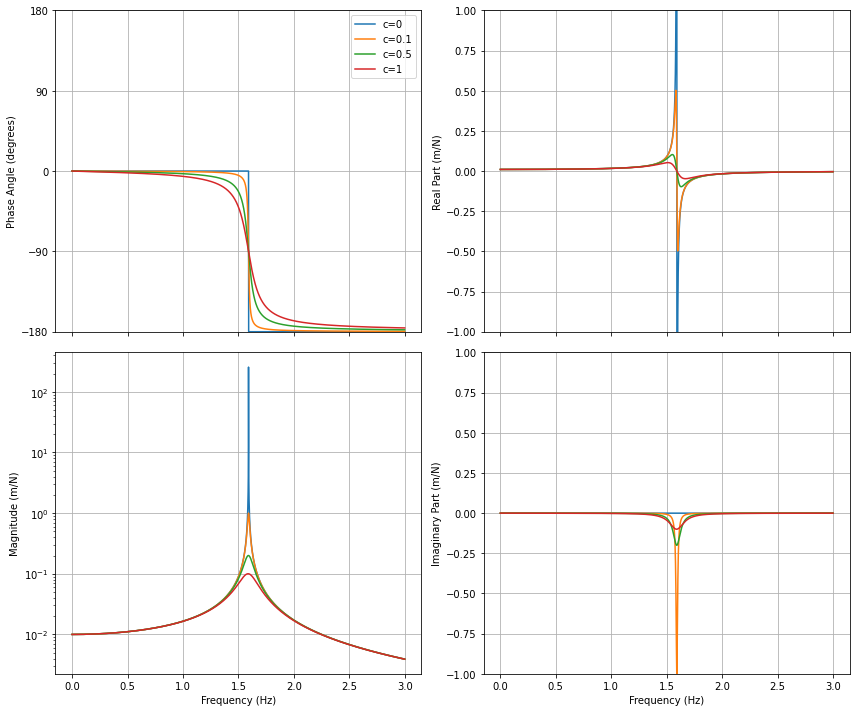

In [11]:
frequencies = np.linspace(0,3,5000)
damping_values = [0,0.1,0.5,1]
fig,ax = plt.subplots(2,2,sharex=True,figsize=(12,10))

for c in damping_values:
    amplification_factor = 1/(-m*(2*np.pi*frequencies)**2 + 1j*c*(2*np.pi*frequencies) + k)
    ax[0,0].plot(frequencies,np.angle(amplification_factor)*180/np.pi)
    ax[1,0].plot(frequencies,np.abs(amplification_factor))
    ax[0,1].plot(frequencies,np.real(amplification_factor))
    ax[1,1].plot(frequencies,np.imag(amplification_factor))

ax[0,0].set_ylabel('Phase Angle (degrees)')
ax[0,0].set_ylim(-180,180)
ax[0,0].set_yticks([-180,-90,0,90,180])
ax[1,0].set_ylabel('Magnitude (m/N)')
ax[1,0].set_yscale('log')
ax[0,1].set_ylabel('Real Part (m/N)')
ax[1,1].set_ylabel('Imaginary Part (m/N)')
ax[1,0].set_xlabel('Frequency (Hz)')
ax[1,1].set_xlabel('Frequency (Hz)')
for a in ax[:,1]:
    a.set_ylim(-1,1)

for a in ax.flatten():
    a.grid(True)

ax[0,0].legend(['c={:}'.format(c) for c in damping_values])
    
fig.tight_layout()

It is worth pointing out some features of the frequency response function here.  First, we have plotted the complex data in two ways.  The left plots show a magnitude and phase plot.  The right two plots show a real and imaginary part.  While these representations highlight different parts of the frequency response function, they plot the same underlying data and are nominally identical.

Starting with the magnitude and phase plots:  we see that there is a peak in the amplitude at the resonant frequency of the part.  We also see that the phase flips from 0 to -180 as the structure goes through resonance, with a phase of -90 degrees corresponding to the resonance location.  We note that while the amplitude peak goes to infinity when the damping is zero, the amplitude peak no longer goes up to infinity when damping is included.  The sharpness of the amplitude peak and damping transition from 0 to -180 degrees depends on the amount of damping, with a larger damping providing a more blunt peak and a slower phase transition.  Because the magnitude often spans multiple orders of magnitude, it is often plotted on a logrithmic scale.  The magnitude and phase representation is probably the most common representation of a frequency response function.

An alternative representation is to plot the real and imaginary part directly.  We see that the real part goes through zero at resonance, and the imaginary part peaks at resonance.  The imaginary part tends to be "sharper" than the magnitude, so it can be useful to look at the imaginary part of the frequency response function when identifying peaks that may be modes of the system.

### Comparison between Displacement, Velocity, and Acceleration Frequency Response Functions

Note that the frequency reponse functions are plotted as the displacement response over the force.  This is intuitive, as we often think about how the part moves when we think about dynamics.  Particularly in experimental dynamics, the practitioner may be exposed to multiple data types.  Accelerometers measure accelerations of the part.  Laser vibrometers measure velocities of the part.  Cameras and other displacement sensors measure displacements.  Therefore, it is useful to become accustomed to what, say, the frequency response function between and acceleration and a force looks like.  This basically requires differentiating the response.

$$x = {X e^{i\omega t}}$$
$$\dot{x} = {i\omega X e^{i\omega t}}$$
$$\ddot{x} = {(i\omega)^2 X e^{i\omega t}} = {-\omega^2 X e^{i\omega t}}$$

We can see that as we go to each additional differentiation from displacement to velocity to acceleration, we simply multiply by $i\omega$

$$ \ddot{x} = i\omega \dot{x} = -\omega^2 x $$

Therefore our frequency response functions look like

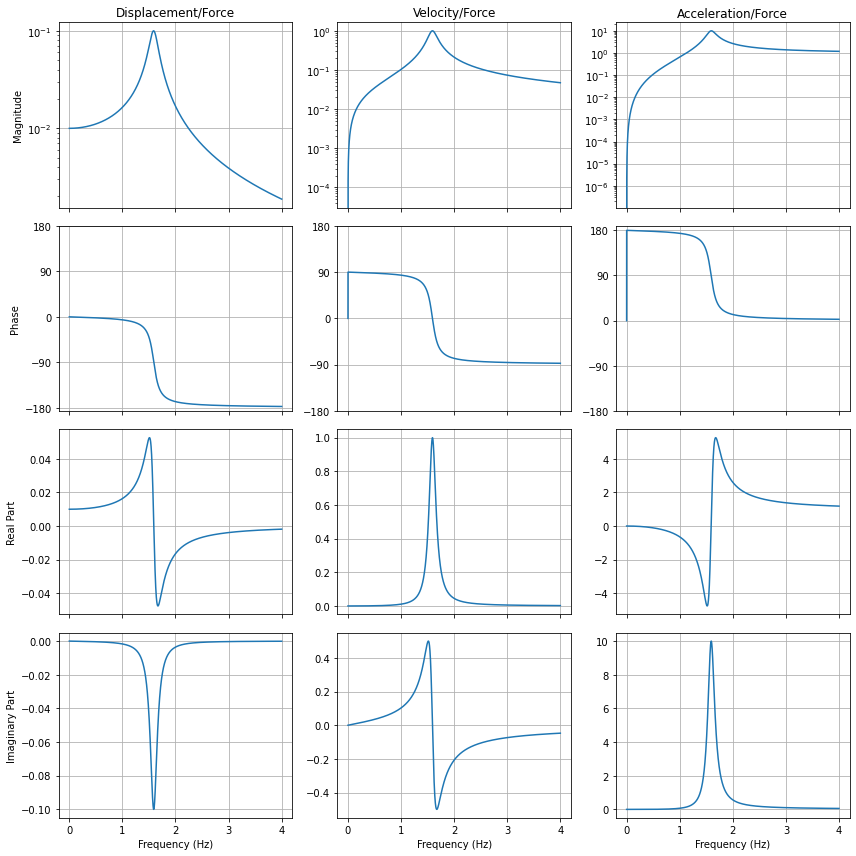

In [12]:
frequencies = np.linspace(0,4,5000)
c = 1
fig,axes = plt.subplots(4,3,sharex=True,figsize=(12,12))
derivatives = [0,1,2]
derivative_labels = ['Displacement/Force','Velocity/Force','Acceleration/Force']
reductions = [np.abs,
              lambda x: np.angle(x)*180/np.pi,
              np.real,
              np.imag]
reduction_labels = ['Magnitude','Phase','Real Part','Imaginary Part']

for label,ax in zip(derivative_labels,axes[0,:]):
    ax.set_title(label)

for label,ax in zip(derivative_labels,axes[-1,:]):
    ax.set_xlabel('Frequency (Hz)')

for ax_row,reduction,label in zip(axes,reductions,reduction_labels):
    ax_row[0].set_ylabel(label)
    for ax,derivative in zip(ax_row,derivatives):
        amplification_factor = ((1j*(2*np.pi*frequencies))**derivative/
                                (-m*(2*np.pi*frequencies)**2 + 1j*c*(2*np.pi*frequencies) + k))
        ax.plot(frequencies,reduction(amplification_factor))
        ax.grid(True)
    
for ax in axes[0,:]:
    ax.set_yscale('log')
    
for ax in axes[1,:]:
    ax.set_yticks([-180,-90,0,90,180])
    
fig.tight_layout()

Briefly comparing these plots, we can highlight some important differences.

Looking first at the magnitude plots in the first row, we see that at low frequency, the displacement will tend to approach a value.  This value is the static stiffness of the spring, because as we go to zero Hz, it is the same as applying a constant force to the structure.  For this same reason, the acceleration and velocity will trend towards zero as the frequency trends towards a constant force: when the system is undergoing a static deflection, it is no longer moving or accelerating, but maintaining a constant displacement.

At the high frequency, the displacement frequency response function will trend towards zero motion as the frequency goes to infinity.  This is because the amount of time the force is applied before it switches directions becomes very small, so the part has less opportunity to move before the force switches direction and starts pushing it the other way.  Similarly, as the acceleration will approach the value obtained if there were no spring on the system, which can be obtained by the formula $F = ma$, because as the displacements go to zero, the influence of the spring also goes to zero, so the acceleration frequency response function becomes dominated by inertial effects.

The phase plots all look similar for each data type, noting, however that the phase becomes undefined at zero frequency because the amplitude becomes zero.  Because the velocity is 90 degrees out of phase with the displacement and the acceleration is 180 degrees out of phase with the displacement, we see the phase plots shifted appropriately.

The real and imaginary parts are also similar, with the main exception being that the real and imaginary parts look "swapped" for the velocity, which is due to the fact that the velocity is 90 degrees out of phase with both acceleration and displacement.  A 90 degree rotation effectively switches the real and imaginary parts (though one of the components will have its sign flipped depending on whether or not the rotation is +90 or -90 degrees).

Note that the above trends are generally only valid for a part that is fixed to ground or attached by a spring.  A "free" or "floating" structure, for example, would tend to have infinite displacement and flat acceleration at zero frequency, due to the fact that a constant force will cause a floating structure to move away indefinitely at a constant acceleration.  We will examine floating structures when we talk about multiple degrees of freedom in subsequent tutorials.

## Working with Single Degree of Freedom Systems in SDynPy
The previous sections have presented some of the theory behind single degree of freedom vibration.  Code has been presented to create the visualizations; however, this section will be a more rigorous demonstration of how we can use Python and SDynPy to investigate single degree of freedom systems.

The key data type in SDynPy for working with mass/spring/damper systems is the `sdpy.System` object.  This object accepts mass, stiffness, and damping values, and stores them along with coordinate information for each degree of freedom.  Note that for single degree of freedom systems, we only have one degree of freedom, so it might sound unnecessary to give a name to the degree of freedom, but the `sdpy.System` object is designed to handle multi-degree of freedom systems, where it is hugely important to keep track of which degree of freedom is which.  Degrees of freedom can be defined with the `sdpy.coordinate_array` function, which allows definition of degree of freedom information.  Let's create a demonstration object now, with different parameters than we used before.

In [13]:
import sdynpy as sdpy

degree_of_freedom = sdpy.coordinate_array(1,'X+')
mass = 5
stiffness = 1000
damping = 2.5
system = sdpy.System(degree_of_freedom,mass,stiffness,damping)

If we just type our system into the Python console, we see that it lists the number of degrees of freedom in the system.

In [14]:
system

System with 1 DoFs (1 internal DoFs)

We can access the mass, stiffness, or damping matrices in the system using the `M`, `K`, or `C` properties, or `mass`, `stiffness` or `damping` properties, respectively.  Note that even for a single degree of freedom system, these will still be 2D arrays due to the possibility of using multiple degrees of freedom in a system object.

In [15]:
system.M

array([[5]])

System objects have a number of functions that are useful for analyzing dynamics problems.  For example, we can easily compute the frequency response function.  We will use Numpy's array functions to construct a set of frequencies at which we will compute the frequency response function.  We can also specify the response derivative (0 - displacement, 1 - velocity, 2 - acceleration).  This provides a `TransferFunctionArray` object which contains the frequency response function.  We can easily plot it by using its `plot` method.

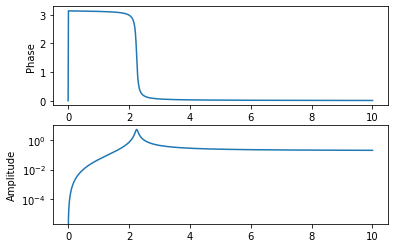

In [16]:
frequencies = np.linspace(0,10,1000)
frf = system.frequency_response(frequencies,displacement_derivative = 2)
frf.plot();

To access the underlying data, we can use the `abscissa` and `ordinate` fields.  Note that the shape of the object might seem a bit strange, but this is primarily due to the fact that there could be multiple degrees of freedom.  The shape of (1, 1, 1000) means there is 1 response location, 1 input location, and 1000 frequency lines.  Note that the data is also a complex number (Python uses `j` to denote $\sqrt(-1)$ rather than `i`).

In [17]:
print('FRF Data Shape: {:}'.format(frf.ordinate.shape))

FRF Data Shape: (1, 1, 1000)


Another capability of the `System` object is to produce response data to an applied force.  We can, for example, set up an input force that we would want to apply to the structure and integrate the equations of motion to produce a time response.  This occurs in the `time_integrate` method of the `System` object.  We can again specify a displacement derivative to the system to specify if we would like displacement, velocity, or acceleration data out from the system.  We can also specify an integration oversampling to ensure that the integration is performed accurately.

SDynPy offers a number of functions defining standard excitation signals in its `generator` package, so we can easily put together a sinusoidal excitation to apply to the structure.

Text(0.5, 0, 'Time (s)')

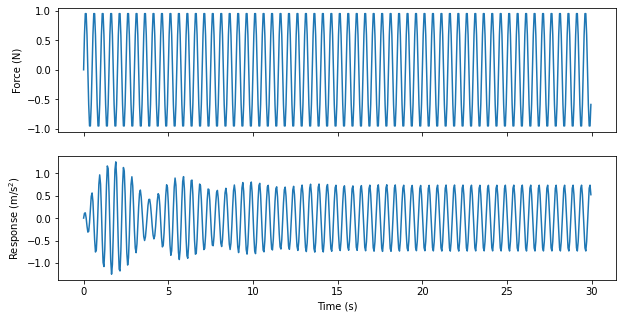

In [18]:
frequency = 2 # Hz
dt = 1/20 # 10 samples per cycle of the 2 Hz sine wave
num_samples = 600 # 30 seconds of data, to let any transients die out
force_signal = sdpy.generator.sine(frequency,dt,num_samples)

responses,references = system.time_integrate(force_signal,dt,displacement_derivative=2,integration_oversample=10)

fig,ax = plt.subplots(2,1,num='Time Integration',figsize=(10,5),sharex=True)
responses.plot(ax[1])
references.plot(ax[0])
ax[0].set_ylabel('Force (N)')
ax[1].set_ylabel('Response (m/s$^2$)')
ax[1].set_xlabel('Time (s)')

We can see in the above, after we let the startup transients die away, the system reaches a steady state after about 20 seconds.  We can look at the frequency response function to see what the expected level and phase should be based on the frequency of excitation.

In [19]:
frequency_line = np.argmin(np.abs(frf[0,0].abscissa-frequency))
frf_value = frf.ordinate[0,0,frequency_line]
print('Frequency Response Function at 2 Hz: {:0.2f} Amplitude, {:0.2f} Phase'.format(
    np.abs(frf_value),np.angle(frf_value)*180/np.pi))

Frequency Response Function at 2 Hz: 0.75 Amplitude, 171.44 Phase


And now if we plot the steady state time data, we can see if that matches our time response.  Note that because our force amplitude was 1, the amplitude of the frequency response function will be the amplitude of the response.  If, for example, the amplitude of the force was some value other than 1, we would need to scale the frequency response value by the force amplitude to predict the response amplitude.

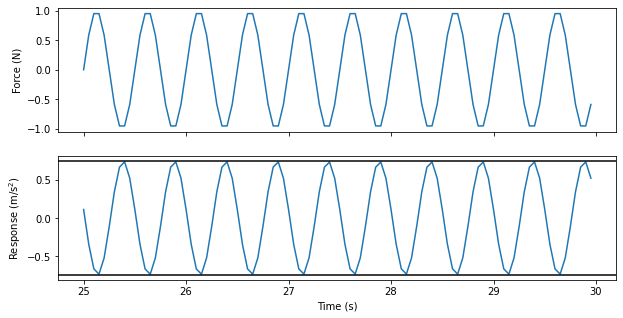

In [20]:
fig,ax = plt.subplots(2,1,num='Time Integration',figsize=(10,5),sharex=True)
responses.extract_elements_by_abscissa(25,np.inf).plot(ax[1])
references.extract_elements_by_abscissa(25,np.inf).plot(ax[0])
ax[0].set_ylabel('Force (N)')
ax[1].set_ylabel('Response (m/s$^2$)')
ax[1].set_xlabel('Time (s)')

ax[1].axhline(np.abs(frf_value),color='k')
ax[1].axhline(-np.abs(frf_value),color='k');

Indeed, the amplitude predicted by the frequency response function matches the amplitude of our response time history.  Also, we see that the response is nearly 180 degrees out of phase with the force (force hits its maximum value when response hits its minimum), which agrees with the predicted phase difference.

## Summary

In this tutorial, we investigated single degree of freedom systems.  We introduced the frequency response function, which is a ratio of the response amplitude to phase amplitude at a given frequency, as well a the phasing between the two signals.  We looked at both undamped and damped systems, and looked at how the response of the system changes with damping.  Finally we looked at how we can investigate these objects using SDynPy.

## Homework Problems

This section contains some example problems to see if you can use SDynPy on your own to set up and analyze a single degree of freedom system.

### 1. Set up a System
Create a system object with $m=20$, $k = 15000$, and $c = 30$ using SDynPy.

### 2. Compute the Frequency Response Function
Compute the frequency response function for the system from Problem 1 and plot the phase, amplitude, real, and imaginary parts.  Plot the frequency response function from 0 to 10 Hz, with a frequency resolution fine enough to see the features of the frequency response function.

### 3. Investigate Design Changes
The system from Problem 1 is undergoing some design changes to modify the resonant frequency.  Change the mass and stiffness of the system by +/-5% to identify what happens to the resonant frequency.  Does the frequency increase or decrease as mass increases?  Does the frequency increase or decrease as stiffness increases?

### 4. Investigate Damping Changes
The system from Problem 1 is still responding too high, so we would like to increase the damping.  First, compute the percent of critical damping that the system currently has.  Now, increase the fraction of critical damping of the system by 20% and 40%.  Plot the frequency response functions for the light damping, medium damping, high damping systems.  How is the peak of the frequency response function changing?  Is it changing in amplitude?  Is it changing in frequency?